## Imports

In [6]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import os

from sklearn.naive_bayes import ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils import resample

## Configs

In [10]:
dataset_filename = 'df_price_cross_cameras'
dataset_name     = 'df_price_cross_cameras'
bert_name        = f'{dataset_name}_bert'
force_bert       = False
glove_name       = f'{dataset_name}_glove'
force_glove      = False
word2vec_name    = f'{dataset_name}_word2vec'
force_word2vec   = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [13]:
dataset_filename = 'df_price_cross_tvs'
dataset_name     = 'df_price_cross_tvs'
bert_name        = f'{dataset_name}_bert'
force_bert       = False
glove_name       = f'{dataset_name}_glove'
force_glove      = False
word2vec_name    = f'{dataset_name}_word2vec'
force_word2vec   = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [ ]:
dataset_filename = 'df_skroutz_cpus_select_12'
dataset_name     = 'df_skroutz'
bert_name        = f'{dataset_name}_bert'
force_bert       = False
glove_name       = f'{dataset_name}_glove'
force_glove      = False
word2vec_name    = f'{dataset_name}_word2vec'
force_word2vec   = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

## Read Data

In [14]:
df = pd.read_parquet(f"../../Datos/products_csv/{dataset_filename}.parquet")
df.head(5)

,ProductID,VendorID,ClusterID,ClusterLabel,CategoryID,CategoryLabel,ProductID2,VendorID2,ClusterID2,ClusterLabel2,CategoryID2,CategoryLabel2,same_product
0,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs,True
1,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs,49inch uhd 4k led smart tv hdr 10 tvplus,123,4419,Samsung UE49NU7100,2614,TVs,True
2,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs,ue49nu7100 49 inch 4k ultra hd hdr smart led tv,124,4419,Samsung UE49NU7100,2614,TVs,True
3,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs,samsung ue49nu7100 49 smart 4k ultra hd hdr le...,7,4419,Samsung UE49NU7100,2614,TVs,True
4,samsung ue49nu7100 49 ultra hd certified hdr s...,32,4419,Samsung UE49NU7100,2614,TVs,samsung ue49nu7100 49 inch 4k ultra hd certifi...,17,4419,Samsung UE49NU7100,2614,TVs,True


## Balance Dataset
Esto es pa balancear las clases y que tengan un numero de lables igual.

In [15]:
def balance_dataset(df: pd.DataFrame, text_column1: str, text_column2: str, target_column: str) -> pd.DataFrame:
    """
    Balances a dataset by upsampling the minority class using ComplementNB.

    :param df: DataFrame containing the data to balance
    :param text_column1: The name of the first text column to vectorize
    :param text_column2: The name of the second text column to vectorize
    :param target_column: The name of the target column
    :return: Balanced DataFrame
    """
    
    df_balanced_upsampled = df

    min_class_count = min(df_balanced_upsampled[target_column].value_counts())
    df_final = pd.concat([
        df_balanced_upsampled[df_balanced_upsampled[target_column] == 0].head(min_class_count),
        df_balanced_upsampled[df_balanced_upsampled[target_column] == 1].head(min_class_count)
    ])
    
    df_final = df_final.sample(frac=1, random_state=123).reset_index(drop=True)

    return df_final[[text_column1, text_column2, target_column]], df_final[list(set(df.columns).difference({'ProductID', 'ProductID2', 'same_product'}))]

df_input, df_results = balance_dataset(df, 'ProductID', 'ProductID2', 'same_product')
df_input.head(5)

,ProductID,ProductID2,same_product
0,hisense 55 inch 55u7auk smart 4k uhd tv with hdr,hisense h55u7a 55inch 4k ultra hd hdr smart ul...,True
1,samsung nu7100 led tv in charcoal black,samsung ue49nu7100kxxu uhd smart tv ue49nu7100...,True
2,49inch uhd 4k led smart tv hdr 10 tvplus,65inch 4k hdr oled smart tv twin tuners wifi b...,False
3,panasonic tx 24e302b 720p hd ready 24 inch led...,panasonic 24 inch 24tx 24e302 hd ready tv,True
4,samsung ue49nu7100 49 ultra hd certified hdr s...,samsung ue24h4003 24 led freeview tv hd ready,False


# Embedding

## BERT

In [9]:
def bert_emb(df: pd.DataFrame):
    if not os.path.exists(f'./{bert_name}.parquet') or force_bert:
        # Load pre-trained BERT tokenizer and model
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained('bert-base-uncased')
        model.to(device)
        model.eval()

        def encode_text(text: str):
            """Encodes a given text using BERT and returns the embedding."""
            inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            inputs = {key: value.to(device) for key, value in inputs.items()}  # Move inputs to GPU if available
            with torch.no_grad():
                outputs = model(**inputs)
            return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()  # Get the embedding

        def encode_column(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
            """Encodes a column of a DataFrame using BERT embeddings."""
            embeddings = []
            for text in tqdm(df[column_name], desc=f'Encoding {column_name}'):
                embeddings.append(encode_text(text))
            df[f'{column_name}_bert'] = embeddings
            return df

        # Apply BERT encoding to both columns
        df = encode_column(df, 'ProductID')
        df = encode_column(df, 'ProductID2')

        # Save the dataframe with BERT embeddings
        df.to_parquet(f'{bert_name}.parquet', index=False)
        print('BERT embeddings have been added and the dataset is saved.')

bert_emb(df_input)

## GloVe

In [10]:
import os
import pandas as pd
import numpy as np
import torch
import torchtext
from tqdm import tqdm

# Load pre-trained GloVe vectors from torchtext
glove = torchtext.vocab.GloVe(name='6B', dim=300)

def glove_emb(df: pd.DataFrame, column1: str, column2: str):
    """
    Encode text columns in a DataFrame using GloVe embeddings.

    :param df: pd.DataFrame - DataFrame containing the text columns to encode
    :param column1: str - Name of the first column to encode
    :param column2: str - Name of the second column to encode
    :param glove_name: str - Name to save the resulting DataFrame with GloVe embeddings
    :param force_glove: bool - Force re-encoding even if the file exists
    """
    if not os.path.exists(f'./{glove_name}.parquet') or force_glove:
        
        def encode_text(text: str) -> np.ndarray:
            """Encodes a given text using GloVe and returns the embedding."""
            words = text.split()
            word_vectors = [glove[word].numpy() for word in words if word in glove.stoi]
            if not word_vectors:
                return np.zeros(glove.dim)
            return np.mean(word_vectors, axis=0)

        def encode_column(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
            """Encodes a column of a DataFrame using GloVe embeddings."""
            embeddings = []
            for text in tqdm(df[column_name], desc=f'Encoding {column_name}'):
                embeddings.append(encode_text(text))
            df[f'{column_name}_glove'] = embeddings
            return df

        # Apply GloVe encoding to both columns
        df = encode_column(df, column1)
        df = encode_column(df, column2)

        # Save the dataframe with GloVe embeddings
        df.to_parquet(f'{glove_name}.parquet', index=False)
        print('GloVe embeddings have been added and the dataset is saved.')

glove_emb(df_input, 'ProductID', 'ProductID2')


## Word2Vec

Requirements:
</br>
pip install spacy
</br>
python -m spacy download en_core_web_md
</br>
conda install -c conda-forge gensim

In [16]:
import os
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
from tqdm import tqdm

# Ensure the correct path to the pre-trained Word2Vec vectors
word2vec_path = '../../Datos/BinModels/GoogleNews-vectors-negative300.bin'

# Load pre-trained Word2Vec vectors
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

def word2vec_emb(df: pd.DataFrame, column1: str, column2: str):
    """
    Encode text columns in a DataFrame using Word2Vec embeddings.

    :param df: pd.DataFrame - DataFrame containing the text columns to encode
    :param column1: str - Name of the first column to encode
    :param column2: str - Name of the second column to encode
    :param word2vec_name: str - Name to save the resulting DataFrame with Word2Vec embeddings
    :param force_word2vec: bool - Force re-encoding even if the file exists
    """
    if not os.path.exists(f'../../Datos/embeddings/{word2vec_name}.parquet') or force_word2vec:
        
        def encode_text(text: str) -> np.ndarray:
            """Encodes a given text using Word2Vec and returns the embedding."""
            words = text.split()
            word_vectors = [word2vec[word] for word in words if word in word2vec]
            if not word_vectors:
                return np.zeros(word2vec.vector_size).astype(np.float32)
            return np.mean(word_vectors, axis=0).astype(np.float32)

        def encode_column(df: pd.DataFrame, column_name: str) -> pd.DataFrame:
            """Encodes a column of a DataFrame using Word2Vec embeddings."""
            embeddings = []
            for text in tqdm(df[column_name], desc=f'Encoding {column_name}'):
                embeddings.append(encode_text(text))
            df[f'{column_name}_word2vec'] = embeddings
            return df

        # Apply Word2Vec encoding to both columns
        df = encode_column(df, column1)
        df = encode_column(df, column2)

        # Save the dataframe with Word2Vec embeddings
        df.to_parquet(f'../../Datos/embeddings/{word2vec_name}.parquet', index=False)
        print('Word2Vec embeddings have been added and the dataset is saved.')

# Example usage
word2vec_emb(df_input, 'ProductID', 'ProductID2')

Encoding ProductID2: 100%|██████████| 45476/45476 [00:00<00:00, 54750.25it/s]


Word2Vec embeddings have been added and the dataset is saved.


# Distance Calculations

## Read Sets

In [12]:
df_bert = pd.read_parquet(f'./{bert_name}.parquet')
df_glove = pd.read_parquet(f'./{glove_name}.parquet')
df_word2vec = pd.read_parquet(f'./{word2vec_name}.parquet')

df_bert.rename({
    "ProductID_bert": "ProductID_enc",
    "ProductID2_bert": "ProductID2_enc"
}, axis=1, inplace=True)
df_glove.rename({
    "ProductID_glove": "ProductID_enc",
    "ProductID2_glove": "ProductID2_enc"
}, axis=1, inplace=True)
df_word2vec.rename({
    "ProductID_word2vec": "ProductID_enc",
    "ProductID2_word2vec": "ProductID2_enc"
}, axis=1, inplace=True)

## Traditional

In [13]:
from scipy.spatial.distance import euclidean, cityblock, cosine, hamming, jaccard
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

def compute_distances(df, col1 = "ProductID_enc", col2 = "ProductID2_enc"):
    df['euclidean_distance'] = df.apply(lambda row: euclidean(np.array(row[col1]), np.array(row[col2])), axis=1)
    df['cosine_distance'] = df.apply(lambda row: 1 - cosine_similarity([np.array(row[col1])], [np.array(row[col2])])[0][0], axis=1)
    df['manhattan_distance'] = df.apply(lambda row: cityblock(np.array(row[col1]), np.array(row[col2])), axis=1)
    df['hamming_distance'] = df.apply(lambda row: hamming(np.array(row[col1]) > 0, np.array(row[col2]) > 0), axis=1)  # Assuming binary values
    df['jaccard_distance'] = df.apply(lambda row: jaccard(np.array(row[col1]) > 0, np.array(row[col2]) > 0), axis=1)  # Assuming binary values
    df['pearson_correlation'] = df.apply(lambda row: 1 - pearsonr(np.array(row[col1]), np.array(row[col2]))[0], axis=1)  # As a distance measure

compute_distances(df_bert)
df_bert

# Compute distances for the first two embeddings from each sample
# distances_glove = compute_distances(df_glove.iloc[0].values, df_glove.iloc[1].values)
# distances_word2vec = compute_distances(df_word2vec.iloc[0].values, df_word2vec.iloc[1].values)
# distances_bert = compute_distances(df_bert.iloc[0].values, df_bert.iloc[1].values)


,ProductID,ProductID2,same_product,ProductID_enc,ProductID2_enc,euclidean_distance,cosine_distance,manhattan_distance,hamming_distance,jaccard_distance,pearson_correlation
0,amd ryzen 5 1600 wraith,amd ryzen 5 1600 6 core processor 3.2ghz yd160...,True,"[0.14828873, -0.107446216, 0.28941366, -0.1422...","[-0.20166567, -0.097035624, 0.79403275, -0.073...",6.424676,2.524093e-01,140.579971,0.246094,0.399577,0.252708
1,intel core i5 7500 bx80677i57500,cpu intel 1151 i5 7500 3 4 ghz,True,"[0.06032281, 0.032935802, 0.31918013, -0.25353...","[-0.109159835, -0.081806436, 0.5844754, 0.0410...",5.220773,1.522914e-01,114.646599,0.166667,0.285078,0.152461
2,amd ryzen 5 1600,intel core i5 7600k processor 6m cache up to 4...,False,"[-0.03539613, 0.153773, 0.44674116, -0.3886112...","[-0.18215542, -0.09753036, 0.6245429, -0.16617...",9.201011,4.699609e-01,204.462891,0.347656,0.525591,0.470582
3,amd ryzen 5 1600 eos 24 dosis,intel celeron g3900 2800 1151 box,False,"[-0.17242604, 0.044528637, 0.37477106, -0.0940...","[-0.046081726, -0.09379666, 0.5733825, 0.06344...",6.244158,2.463510e-01,138.387848,0.264323,0.423800,0.246642
4,amd ryzen 5 1600 box pliromi ke se eos 36 dosis,epexergastis amd ryzen 5 1600 6 core processor...,True,"[0.007652113, 0.068989575, -0.045789562, 0.091...","[-0.07818306, -0.10073437, 0.7656653, -0.02333...",7.873281,3.497567e-01,173.567688,0.332031,0.503953,0.350102
...,...,...,...,...,...,...,...,...,...,...,...
63519,epexergastis intel xeon e5 2609v3 1.9ghz/6 cor...,epexergastis intel xeon e5 2609v3 1.9ghz/6 cor...,True,"[-0.07879775, -0.078688234, 0.56213796, -0.173...","[-0.07879775, -0.078688234, 0.56213796, -0.173...",0.000000,-1.192093e-07,0.000000,0.000000,0.000000,0.000000
63520,amd ryzen 5 1600 box am4 3 4 ghz,intel cpu pentium g4620 bx80677g4620,False,"[-0.054758944, -0.15059578, 0.82381946, 0.1116...","[-0.08369434, -0.112629585, 0.34375677, -0.348...",7.229160,2.986745e-01,160.699341,0.277344,0.443750,0.299050
63521,epexergastis amd ryzen 5 1600 6 core processor...,epexergastis amd ryzen 7 2700x 8 core 3.7ghz a...,False,"[-0.07818306, -0.10073437, 0.7656653, -0.02333...","[-0.036090832, 0.03166049, 0.65665257, -0.1725...",3.145786,5.592155e-02,68.686424,0.136719,0.239180,0.055977
63522,amd ryzen 5 1600 eos 24 dosis,epexergastis amd a8 9600 am4 3.40ghz 2mb ad960...,False,"[-0.17242604, 0.044528637, 0.37477106, -0.0940...","[-0.059494272, 0.14483944, 0.50830567, -0.4456...",6.320656,2.433377e-01,137.886215,0.244792,0.401709,0.243621


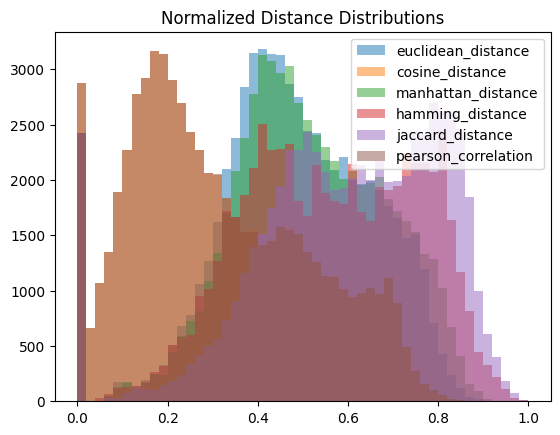

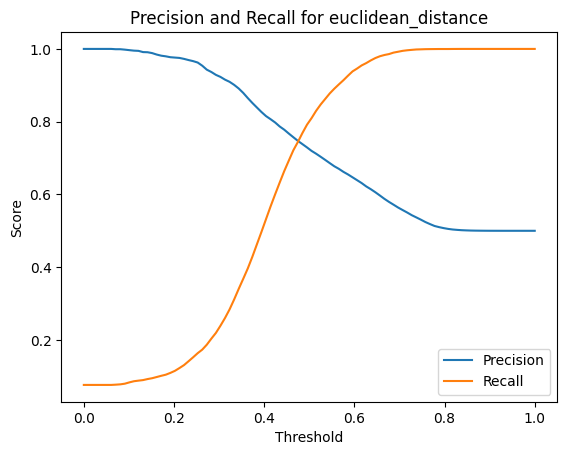

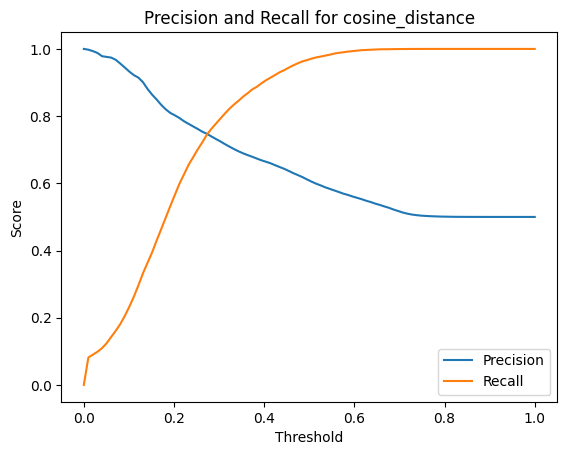

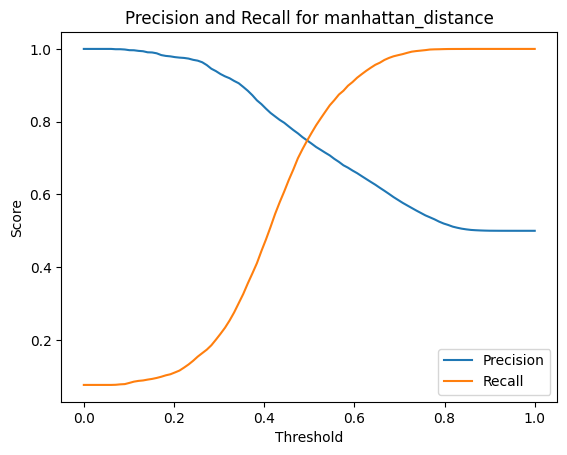

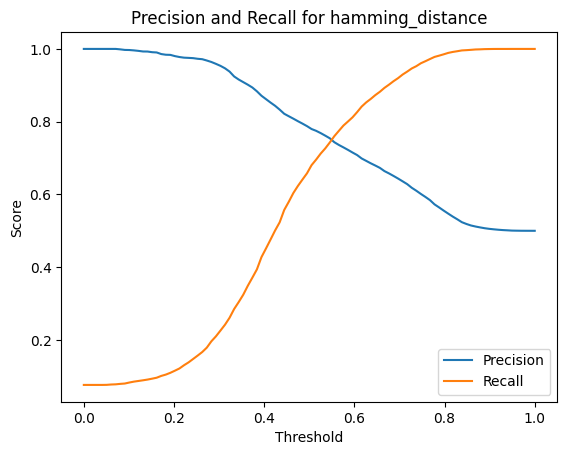

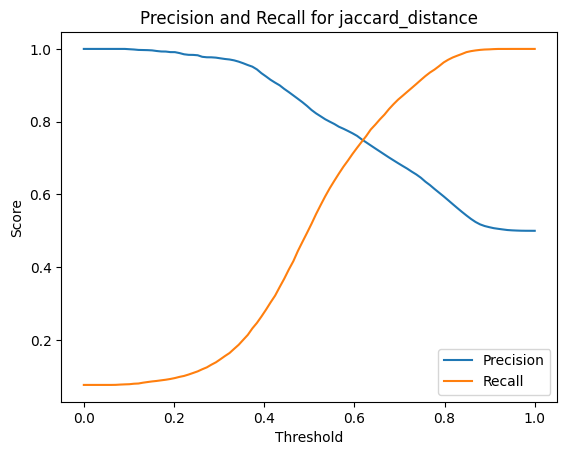

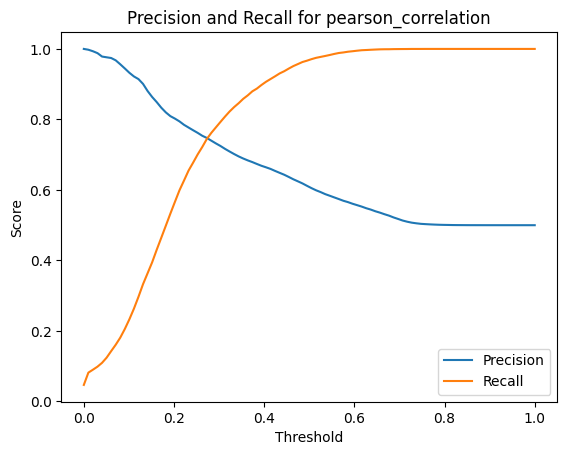

,distance_metric,precision,recall,optimal_threshold
0,euclidean_distance,0.631182,0.954663,0.616162
1,cosine_distance,0.624520,0.957307,0.474747
2,manhattan_distance,0.626697,0.956363,0.646465
3,hamming_distance,0.628286,0.937661,0.717172
4,jaccard_distance,0.625621,0.935143,0.767677
5,pearson_correlation,0.630248,0.951325,0.464646


In [14]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import euclidean, cityblock, cosine, hamming, jaccard
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt

# Normalize the distances to [0, 1] range
for col in ['euclidean_distance', 'cosine_distance', 'manhattan_distance', 'hamming_distance', 'jaccard_distance', 'pearson_correlation']:
    min_val = df_bert[col].min()
    max_val = df_bert[col].max()
    df_bert[col] = (df_bert[col] - min_val) / (max_val - min_val)

# Check distance distributions after normalization
for col in ['euclidean_distance', 'cosine_distance', 'manhattan_distance', 'hamming_distance', 'jaccard_distance', 'pearson_correlation']:
    plt.hist(df_bert[col], bins=50, alpha=0.5, label=col)
plt.legend(loc='upper right')
plt.title("Normalized Distance Distributions")
plt.show()

# Function to compute precision and recall
def compute_precision_recall(df, distance_column, same_product_column='same_product'):
    precisions = []
    recalls = []
    thresholds = np.linspace(0, 1, 100)

    for threshold in thresholds:
        df[f'predicted_{distance_column}'] = df[distance_column] <= threshold
        precision = precision_score(df[same_product_column], df[f'predicted_{distance_column}'])
        recall = recall_score(df[same_product_column], df[f'predicted_{distance_column}'])
        precisions.append(precision)
        recalls.append(recall)

    best_index = np.argmax(np.array(precisions) + np.array(recalls))
    best_threshold = thresholds[best_index]

    plt.plot(thresholds, precisions, label='Precision')
    plt.plot(thresholds, recalls, label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title(f'Precision and Recall for {distance_column}')
    plt.legend(loc='best')
    plt.show()

    return precisions[best_index], recalls[best_index], best_threshold

# List of distance columns
distance_columns = ['euclidean_distance', 'cosine_distance', 'manhattan_distance', 'hamming_distance', 'jaccard_distance', 'pearson_correlation']

# Compute precision and recall for each distance metric
results = []
for column in distance_columns:
    precision, recall, threshold = compute_precision_recall(df_bert, column)
    results.append({
        'distance_metric': column,
        'precision': precision,
        'recall': recall,
        'optimal_threshold': threshold
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df